In [2]:
import pandas as pd
import numpy as np
from sklearn.metrics import ConfusionMatrixDisplay
import torch
from tqdm import tqdm
import tqdm.notebook
from pathlib import Path

In [3]:
experiments = ["CCA", "dnn", "eegnet", "CCA_dnn", "CCA_eegnet", "CCA_dnn_1_subband"]
df_list = []
for experiment in experiments:
    exp_path = Path(experiment)
    for setup in exp_path.iterdir():
        if setup.is_dir():
            print(f"Experiment: {experiment}, Setup: {setup.name}")
            metrics_path = setup.joinpath("metricas.csv")
            if metrics_path.exists():
                df = pd.read_csv(metrics_path)
                df["experiment"] = experiment
                df["window"] = float(setup.name.split("_")[-2])
                df_list.append(df)
results = pd.concat(df_list, ignore_index=True)

Experiment: CCA, Setup: 10_users_8_freqs_0.4_s
Experiment: CCA, Setup: 10_users_8_freqs_0.6_s
Experiment: CCA, Setup: 10_users_8_freqs_0.8_s
Experiment: CCA, Setup: 10_users_8_freqs_1_s
Experiment: dnn, Setup: 10_users_8_freqs_0.4_s
Experiment: dnn, Setup: 10_users_8_freqs_0.6_s
Experiment: dnn, Setup: 10_users_8_freqs_0.8_s
Experiment: dnn, Setup: 10_users_8_freqs_1_s
Experiment: eegnet, Setup: 10_users_8_freqs_0.4_s
Experiment: eegnet, Setup: 10_users_8_freqs_0.6_s
Experiment: eegnet, Setup: 10_users_8_freqs_0.8_s
Experiment: eegnet, Setup: 10_users_8_freqs_1_s
Experiment: CCA_dnn, Setup: 10_users_8_freqs_0.4_s
Experiment: CCA_dnn, Setup: 10_users_8_freqs_0.6_s
Experiment: CCA_dnn, Setup: 10_users_8_freqs_0.8_s
Experiment: CCA_dnn, Setup: 10_users_8_freqs_1_s
Experiment: CCA_eegnet, Setup: 10_users_8_freqs_0.4_s
Experiment: CCA_eegnet, Setup: 10_users_8_freqs_0.6_s
Experiment: CCA_eegnet, Setup: 10_users_8_freqs_0.8_s
Experiment: CCA_eegnet, Setup: 10_users_8_freqs_1_s
Experiment: CC

In [4]:
results_means = results.drop(
    columns=["confusion_matrix", "recall", "f1-score", "usuario"], inplace=False
)
results_means = results_means.groupby(["experiment", "window"]).mean().reset_index()

In [74]:
results_means

,experiment,window,acuracia
0,CCA,0.4,0.329167
1,CCA,0.6,0.512500
2,CCA,0.8,0.629167
3,CCA,1.0,0.789583
4,CCA_dnn,0.4,0.525000
5,CCA_dnn,0.6,0.631250
6,CCA_dnn,0.8,0.731250
7,CCA_dnn,1.0,0.764583
8,CCA_dnn_1_subband,0.4,0.522917
9,CCA_eegnet,0.4,0.495833


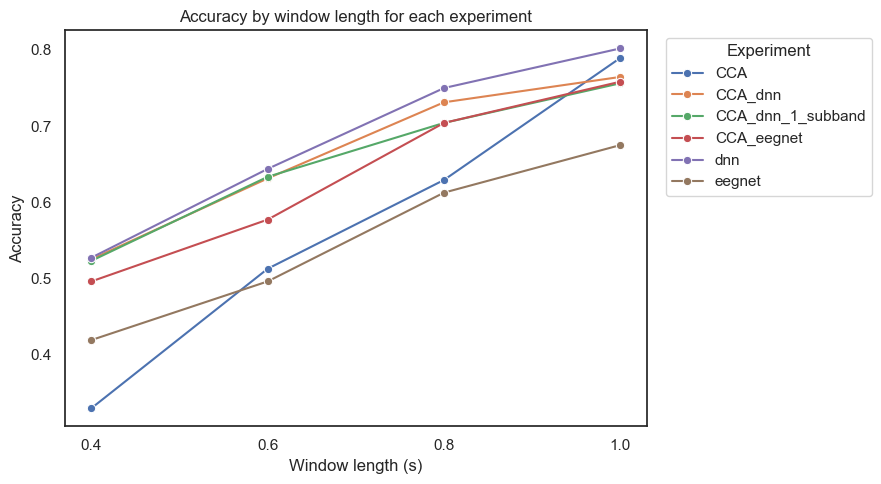

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(9, 5))
sns.set_theme(style="white")

# Line plot with markers per window and distinct colors per experiment
sns.lineplot(data=results_means, x="window", y="acuracia", hue="experiment", marker="o")

plt.xlabel("Window length (s)")
plt.xticks(results_means["window"].unique())
plt.ylabel("Accuracy")
plt.title("Accuracy by window length for each experiment")
plt.legend(title="Experiment", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [ ]:
import ast
import re
import numpy as np

# Build results_cms with parsed confusion matrices
results_cms = results[["experiment", "window", "usuario", "confusion_matrix"]].copy()


def normalize_cm_string(s: str) -> str:
    """Normalize a confusion-matrix string so it becomes valid Python list syntax.
    Handles cases like '[[1 0][0 2]]', '[[1 0 2]\n [3 4 5]]', or missing commas.
    """
    s = s.strip()
    # Ensure outer brackets
    if not s.startswith("["):
        s = "[" + s
    if not s.endswith("]"):
        s = s + "]"

    # Put commas between closing and opening inner brackets: '][" -> '], ['
    s = re.sub(r"\]\s*\[", "], [", s)

    # Insert commas between numbers where whitespace is used as separator
    # e.g. '1 0' -> '1, 0', '1.0 -2' -> '1.0, -2'
    s = re.sub(r"(?<=[0-9\.\-])\s+(?=[0-9\.\-])", ", ", s)

    # Also handle cases like '[1,2 3]' -> ensure comma between '2' and '3'
    s = re.sub(r"(?<=[0-9\.\-]),\s*(?=[0-9\.\-])", ", ", s)

    return s


def parse_cm(cm):
    """Parse a confusion-matrix cell to a numpy array.
    Handles list/ndarray values or string representations with or without commas.
    Returns None for missing/NaN values.
    """
    if cm is None:
        return None
    if isinstance(cm, float) and np.isnan(cm):
        return None
    if isinstance(cm, (list, tuple, np.ndarray)):
        return np.array(cm)
    if isinstance(cm, str):
        s = cm.strip()
        # Normalize common missing-comma formats
        try:
            parsed = ast.literal_eval(s)
        except Exception:
            try:
                # Try normalizing separators and eval again
                s_norm = normalize_cm_string(s)
                parsed = ast.literal_eval(s_norm)
            except Exception:
                # final fallback to eval (only if necessary)
                parsed = eval(s)
        return np.array(parsed)
    # unknown type - try to coerce
    try:
        return np.array(cm)
    except Exception:
        return None


results_cms["cm_array"] = results_cms["confusion_matrix"].apply(parse_cm)

# Drop rows without a valid confusion matrix
results_cms = results_cms[results_cms["cm_array"].notnull()].copy()


# Helper to sum a sequence of confusion matrices (numpy arrays)
def sum_cms(seq):
    total = None
    for cm in seq:
        arr = np.array(cm)
        if total is None:
            total = np.zeros_like(arr, dtype=int)
        total = total + arr.astype(int)
    return total


# Sum per experiment, window, usuario
grouped_cms = (
    results_cms.groupby(["experiment", "window", "usuario"])["cm_array"]
    .apply(lambda s: sum_cms(s))
    .reset_index()
    .rename(columns={"cm_array": "confusion_matrix_sum"})
)

# Also produce a total per experiment & window (summing across usuarios)
grouped_total = (
    grouped_cms.groupby(["experiment", "window"])["confusion_matrix_sum"]
    .apply(lambda s: sum_cms(s))
    .reset_index()
    .rename(columns={"confusion_matrix_sum": "confusion_matrix_sum_all_users"})
)

# Quick sanity checks
print(f"Rows (experiment-window-user): {len(grouped_cms)}")
print(f"Rows (experiment-window total): {len(grouped_total)}")

grouped_cms.head(), grouped_total.head()

Rows (experiment-window-user): 200
Rows (experiment-window total): 20


(  experiment  window  usuario  \
 0        CCA     0.4        1   
 1        CCA     0.4        2   
 2        CCA     0.4        3   
 3        CCA     0.4        4   
 4        CCA     0.4        5   
 
                                 confusion_matrix_sum  
 0  [[1, 1, 0, 1, 2, 1, 0, 0], [2, 1, 2, 1, 0, 0, ...  
 1  [[4, 0, 0, 0, 2, 0, 0, 0], [3, 2, 0, 1, 0, 0, ...  
 2  [[5, 1, 0, 0, 0, 0, 0, 0], [1, 4, 0, 1, 0, 0, ...  
 3  [[3, 2, 1, 0, 0, 0, 0, 0], [0, 5, 1, 0, 0, 0, ...  
 4  [[1, 3, 0, 2, 0, 0, 0, 0], [2, 3, 1, 0, 0, 0, ...  ,
   experiment  window                     confusion_matrix_sum_all_users
 0        CCA     0.4  [[28, 14, 4, 6, 5, 2, 0, 1], [18, 23, 6, 6, 2,...
 1        CCA     0.6  [[45, 4, 2, 6, 1, 2, 0, 0], [6, 32, 6, 6, 7, 2...
 2        CCA     0.8  [[47, 4, 1, 5, 2, 1, 0, 0], [6, 40, 5, 5, 4, 0...
 3        CCA     1.0  [[53, 2, 1, 3, 0, 1, 0, 0], [4, 48, 3, 2, 3, 0...
 4    CCA_dnn     0.4  [[28, 7, 5, 2, 3, 6, 3, 6], [8, 29, 5, 6, 3, 3...)

In [4]:
classes = np.unique(list(range(8, 16)))
disp = ConfusionMatrixDisplay(
    confusion_matrix=grouped_total.iloc[0]["confusion_matrix_sum_all_users"],
    display_labels=classes,
)
fig, ax = plt.subplots(figsize=(15, 15))
disp.plot(ax=ax, cmap="Blues", xticks_rotation="vertical")
plt.show()

NameError: name 'grouped_total' is not defined

In [ ]:
from cross_subject_utils import load_data_from_users

all_data = load_data_from_users(
    [1, 2, 3],
    visual_delay=160,
    filter_bandpass=True,
    sample_rate=250,
)

Carregando dados dos usuários:   0%|          | 0/3 [00:00<?, ?it/s]

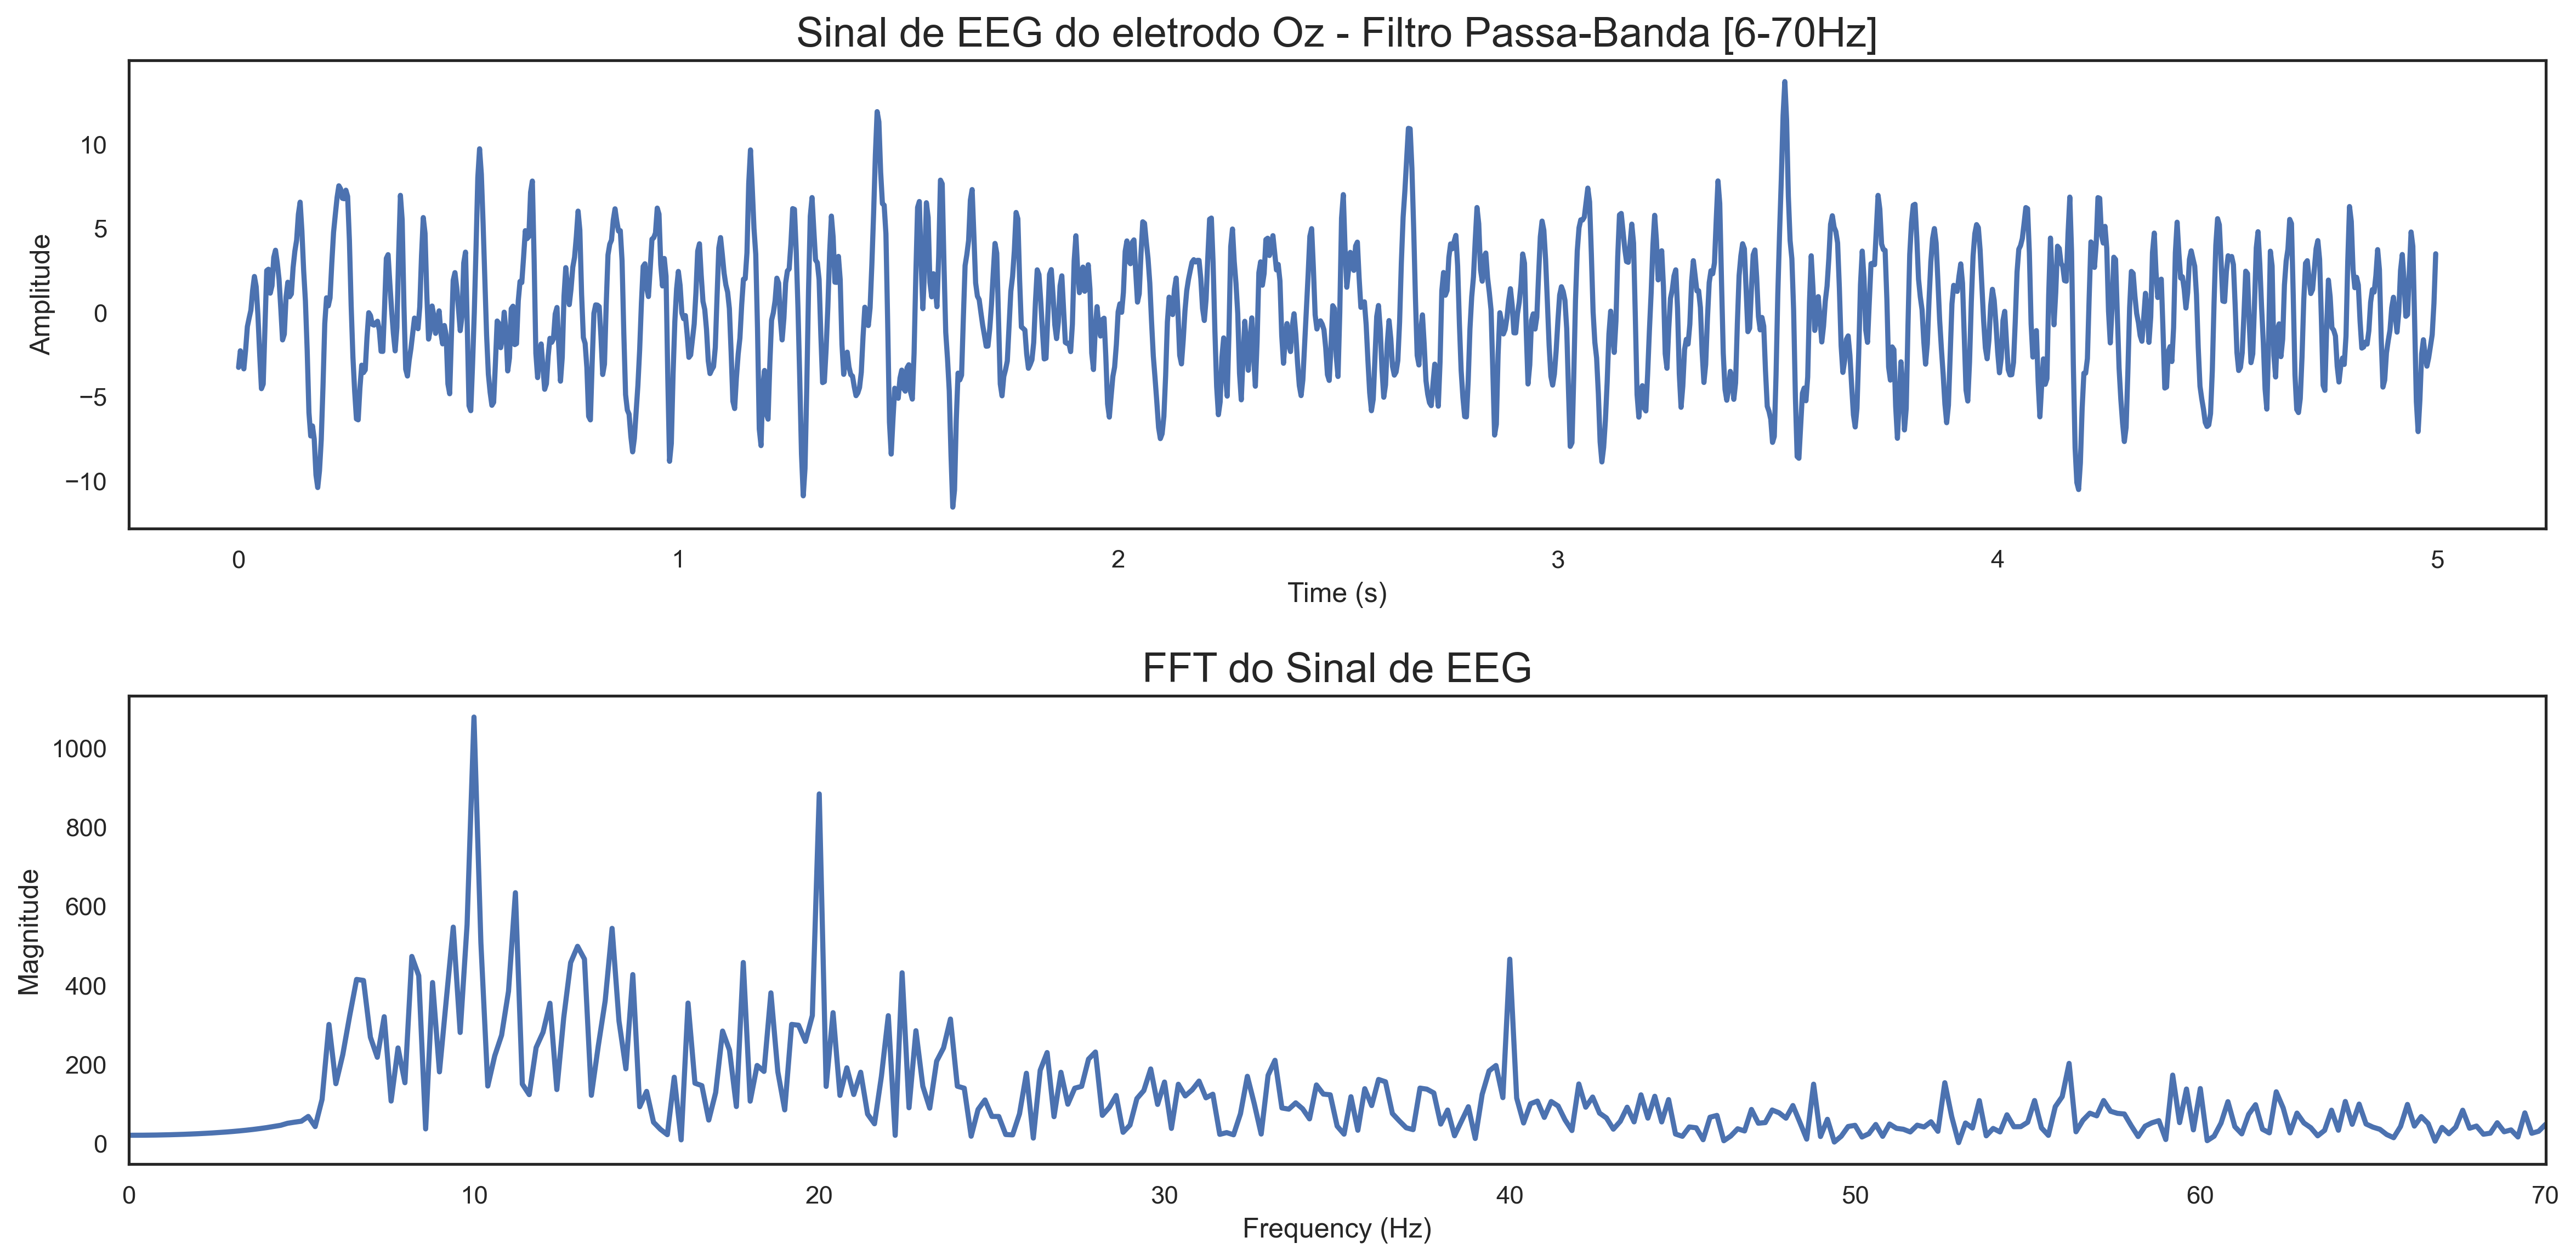

In [ ]:
# Calculate FFT
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

time_data = all_data[2][
    54, :, 2, 2
]  # EEG data from electrode Oz, filtered with bandpass [6-70Hz], frequency 10Hz
freq = np.fft.fftfreq(len(time_data), d=1 / 250)  # 250 Hz sampling rate
fft_data = np.abs(np.fft.fft(time_data))

# Create figure with two subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 8), dpi=300)
sns.set_theme(style="white", context="talk")

# Plot time domain data
sns.lineplot(x=np.arange(len(time_data)) / 250, y=time_data, ax=ax1)
ax1.set_title("Sinal de EEG do eletrodo Oz - Filtro Passa-Banda [6-70Hz]")
ax1.set_xlabel("Tempo (s)")
ax1.set_ylabel("Amplitude")

# Plot frequency domain data (show only positive frequencies)
mask = freq >= 0
sns.lineplot(x=freq[mask], y=fft_data[mask], ax=ax2)
ax2.set_title("FFT do Sinal de EEG")
ax2.set_xlabel("Frequência (Hz)")
ax2.set_xlim(0, 70)  # Limit x-axis to 60 Hz for better visibility
ax2.set_ylabel("Magnitude")

plt.tight_layout()
plt.show()

In [ ]:
import mne

builtin_montages = mne.channels.get_builtin_montages(descriptions=True)

builtin_montages

[('standard_1005',
  'Electrodes are named and positioned according to the international 10-05 system (343+3 locations)'),
 ('standard_1020',
  'Electrodes are named and positioned according to the international 10-20 system (94+3 locations)'),
 ('standard_alphabetic',
  'Electrodes are named with LETTER-NUMBER combinations (A1, B2, F4, …) (65+3 locations)'),
 ('standard_postfixed',
  'Electrodes are named according to the international 10-20 system using postfixes for intermediate positions (100+3 locations)'),
 ('standard_prefixed',
  'Electrodes are named according to the international 10-20 system using prefixes for intermediate positions (74+3 locations)'),
 ('standard_primed',
  "Electrodes are named according to the international 10-20 system using prime marks (' and '') for intermediate positions (100+3 locations)"),
 ('biosemi16', 'BioSemi cap with 16 electrodes (16+3 locations)'),
 ('biosemi32', 'BioSemi cap with 32 electrodes (32+3 locations)'),
 ('biosemi64', 'BioSemi cap w

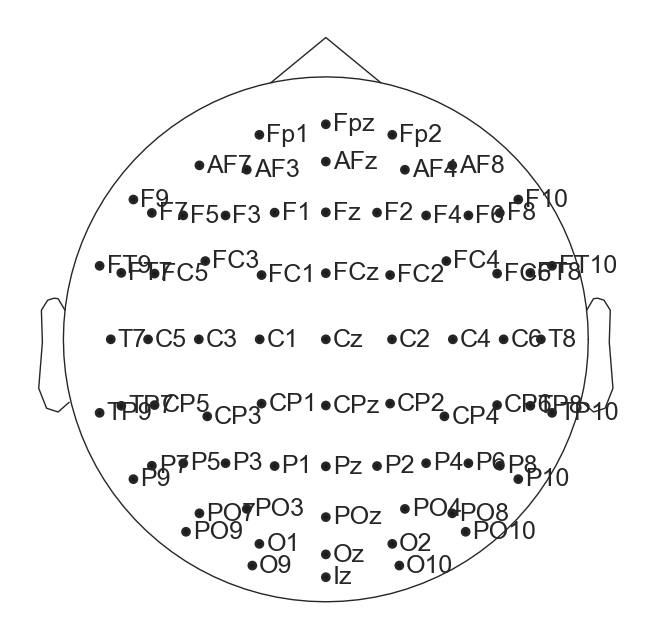

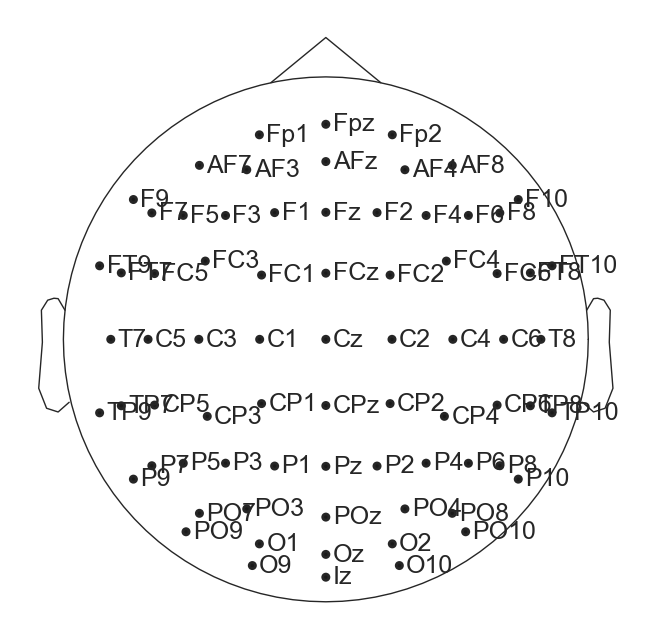

In [54]:
easycap_montage = mne.channels.make_standard_montage("easycap-M1")
easycap_montage.plot()  # 2D